In [1]:
import matplotlib.pyplot as plt
import jax, jax.numpy as jnp, jax.random as jr
from tqdm import trange
import pandas as pd
from minirl.cliff import Cliff
from minirl.util import Buf, get_episode_reward, fill_buffer
from minirl.ppo import expected_reward
from minirl.model import Embedding, EpsGreedy

key = jr.key(0)

In [2]:
# define an epsilon-greedy model with a lookup table
action_tab = Embedding(24, 4)
eps_greedy = EpsGreedy(action_tab, 4, eps=.05)

# initialize model parameters
key, model_key = jr.split(key)
params_init = eps_greedy.init(model_key)

In [3]:
def run_stages(key, params, stages):
  returns, entropies = [], []

  # create trajectory buffer
  buf = Buf(100, max_steps)
  buf_state = buf.empty(buf_size=1000)

  for stage, epochs, name in stages:
    print("running stage", f"\"{name}\"")
    for _ in (pbar := trange(epochs)):
      # generate trajectories
      buf_state = buf_state.reset() # reset buffer instead of always reallocating
      key, ep_key = jr.split(key)
      buf_state = fill_buffer(ep_key, eps_greedy, params, buf, buf_state, stage)

      # compute gradients and update model using gradient ascent
      grads = jax.grad(expected_reward, argnums=1)(eps_greedy, params, buf_state)
      params = jax.tree_util.tree_map(lambda p, g: p + 1e-2 * g, params, grads)

      # bookkeeping
      log_probs = jax.nn.log_softmax(params)
      entropy = (-jnp.mean(log_probs * jnp.exp(log_probs))).item()
      entropies.append(entropy)
      num_eps = buf_state.num_eps.item()
      # compute average return for episodes
      avg_ret = (jnp.sum(get_episode_reward(buf_state)) / buf_state.num_eps).item()
      returns.append(avg_ret)
      pbar.set_description(f"{num_eps=:4d} {avg_ret=:6.01f} {entropy=:6.03f}")
  return params, returns, entropies

# training parameters
key, train_key = jr.split(key)
max_steps = 20

# create a run with stages and one without
stages = [
  (Cliff.reach_goal_without_cliff(max_steps), 100, "reach goal"),
  (Cliff.avoid_walls(max_steps), 50, "avoid walls"),
  (Cliff.avoid_walls_and_cliff(max_steps), 50, "avoid walls and cliff"),
  (Cliff(max_steps=max_steps), 300, "full"),
]
results = {
  "staged": run_stages(train_key, params_init, stages),
  "default": run_stages(train_key, params_init, [(Cliff(max_steps=max_steps), 500, "full")])
}

running stage "reach goal"


num_eps= 101 avg_ret=  43.0 entropy= 0.211: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


running stage "avoid walls"


num_eps=  50 avg_ret=  18.1 entropy= 0.166: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s]


running stage "avoid walls and cliff"


num_eps=  50 avg_ret=  19.1 entropy= 0.149: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s]


running stage "full"


num_eps= 101 avg_ret=  40.6 entropy= 0.112: 100%|██████████| 300/300 [00:45<00:00,  6.53it/s]


running stage "full"


num_eps= 101 avg_ret=  40.6 entropy= 0.158: 100%|██████████| 500/500 [01:16<00:00,  6.56it/s]


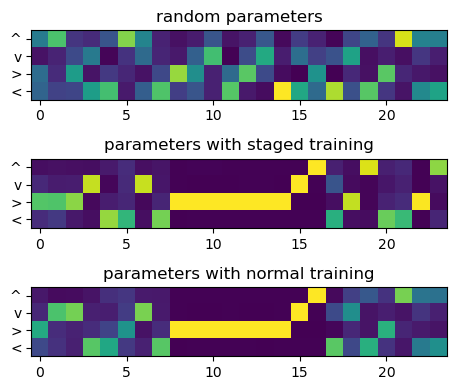

In [4]:
plt.figure(figsize=(8,4))

plt.subplot(3,1,1)
plt.title("random parameters")
plt.yticks(range(4), [*Cliff().ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params_init).T)

plt.subplot(3,1,2)
plt.title("parameters with staged training")
plt.yticks(range(4), [*Cliff().ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(results["staged"][0]).T)

plt.subplot(3,1,3)
plt.title("parameters with normal training")
plt.yticks(range(4), [*Cliff().ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(results["default"][0]).T)

plt.tight_layout();

In [5]:
def mark_stages(stages, text=True):
  i = 0
  for _, l, name in stages:
    i += l
    plt.axvline(i, ls="--", c="k")
    if text:
      plt.text(i - l // 2, 0, name.replace(" ", "\n"), ha="center", va="center")

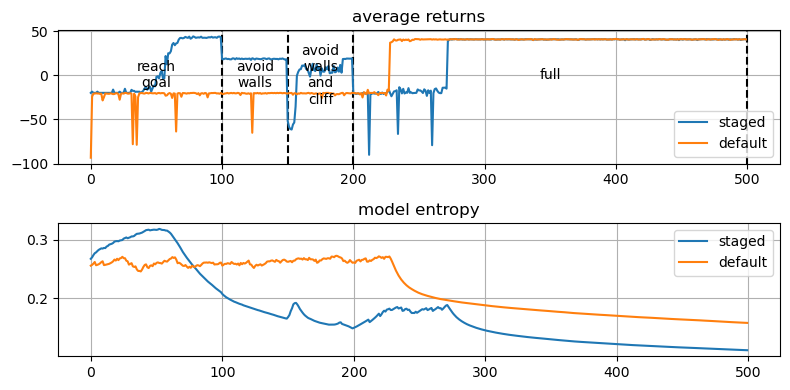

In [6]:
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.title("average returns")
mark_stages(stages)
pd.Series(results["staged"][1]).plot.line(ax=plt.gca(), grid=True, label="staged")
pd.Series(results["default"][1]).plot.line(ax=plt.gca(), grid=True, label="default")
plt.legend()

plt.subplot(2,1,2)
plt.title("model entropy")
pd.Series(results["staged"][2]).plot.line(ax=plt.gca(), grid=True, label="staged")
pd.Series(results["default"][2]).plot.line(ax=plt.gca(), grid=True, label="default")
plt.legend()

plt.tight_layout();

In [7]:
env = stages[-1][0]

In [8]:
def print_greedy_actions(params):
  for y in range(env.height):
    for x in range(env.width):
      action = params[y * env.width + x].argmax().item()
      action = env.ACTION2CHAR[action]
      print(action, end="")
    print()

# print greedy actions
print("random greedy actions:")
print_greedy_actions(params_init)
print()
print("trained greedy actions:")
print_greedy_actions(results["staged"][0])

random greedy actions:
^^><<^^<
>>v<>v<<
><v<>^<<

trained greedy actions:
>>>v<<v<
>>>>>>>v
^<>^<<>^
